In [1]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.animation as animation
# plt.rcParams['animation.html'] = 'html5'

from IPython import display
import time
import ffmpeg

import VlasovSolver

# Two-Stream Instability

### Initial Condition of the model:

$$ f(0,x,v) = \frac{1}{2}\Bigg[ \frac{1}{\sqrt{2 \pi}} e^{-(v-v_0)^2/2} + \frac{1}{\sqrt{2 \pi}} e^{-(v+v_0)^2/2} \Bigg]  (1+\varepsilon\cos(kx))$$

Where $\varepsilon$ controls the perturbation, $k$ is the wave number. $\varepsilon=0.001$ and  $k=0.2$

#### Parameters

- $\varepsilon$ = 0.001
- $k$ = 0.2
- $v\in(-10,10)$
- $x\in(0,2\pi/k)$

In [7]:
eps = 0.001 # perturbation parameter
v_min = -10 # Minimum velocity 
v_max = 10 # Maximum velocity
T_max = 50 # Max time of solution
k_param = 0.2 # wave number
L_x = 2*np.pi / k_param # Size of grid
L_x

31.41592653589793

#### Discretization

In [8]:
N_x = 256 # Position Slots 
N_y = 256 # Velocities Slots 
M_size = 6000 # Divisions of time in M slots 

# Step Sizes:
dx = L_x/N_x
dv = (v_max-v_min)/N_y
dt = T_max/M_size

print(f'Nx: {N_x}     dx: {dx}')
print(f'Ny: {N_y}    dy: {dv}')
print(f'M:  {M_size}   dt: {dt}')

Nx: 256     dx: 0.1227184630308513
Ny: 256    dy: 0.078125
M:  6000   dt: 0.008333333333333333


#### Test the model from 3 different stream velocities

In [9]:
v0_vector = [1.3, 2.4, 3.0] # Stream velocities of electron currents

### First Run: v0 = 1.3

In [10]:
two_stream_init_cond1 = lambda x,v: 1/(2*np.sqrt(2*np.pi))*(np.exp(-(v - v0_vector[0])**2/2) + 
                                                            np.exp(-(v + v0_vector[0])**2/2)) * (1 + eps*np.cos(k_param*x))

#### Run Model

In [11]:
start_time = time.time()

objSolver = VlasovSolver.VlasovPoisson1D1V(two_stream_init_cond1, 0.0 ,L_x , N_x, v_min, v_max, N_y, T_max, M_size, 
                                                 'Spectral', 1 ,'TwoStream1')
Mass_sol,Moment_sol,Energy_sol,L2norm_sol,E_field = objSolver.run_iteration() # run model

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  11.715051651000977


In [12]:
t_grid = objSolver.grid_points(0.0,T_max,dt)[:-1]
t_grid.shape

(6000,)

### Plot the variables evolution in time (Mass, Momentum, Energy and $L^2$ Norm)

In [13]:
def plot_quantity(t_array,var_array,label,var_name,dtime):
    plt.figure(figsize=(10,8))
    plt.plot(t_array,var_array,label = label,c='b')
    plt.title(f"Conservation of Total {var_name} for dt: "+ "%.3f"%dtime,fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel(f'{var_name}',fontsize=14)
    plt.legend()
    plt.show()

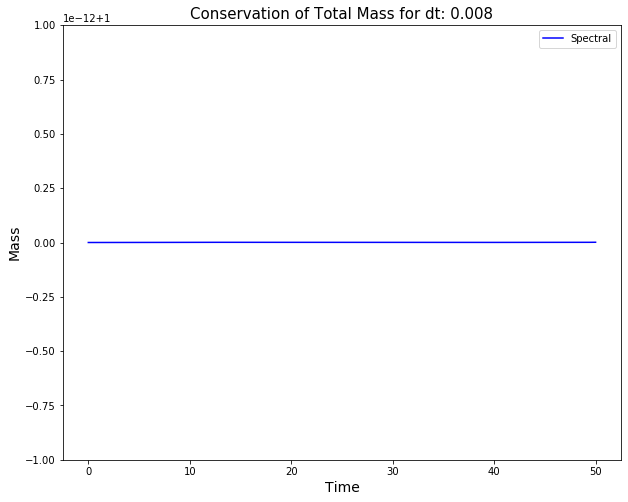

In [14]:
plot_quantity(t_grid,Mass_sol/Mass_sol[0],'Spectral','Mass',dt)

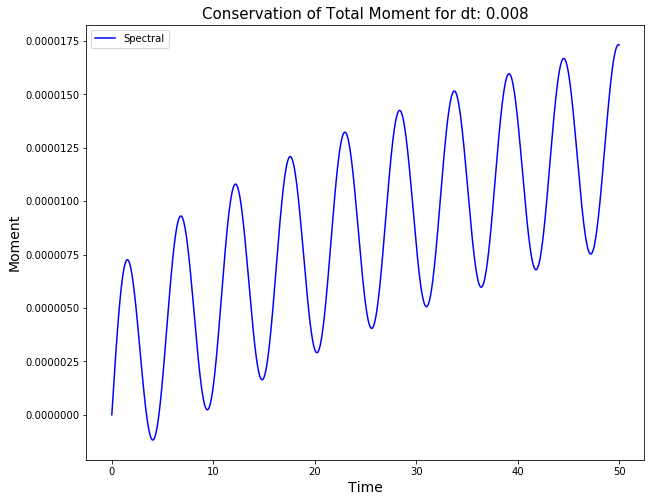

In [15]:
plot_quantity(t_grid,Moment_sol,'Spectral','Moment',dt)

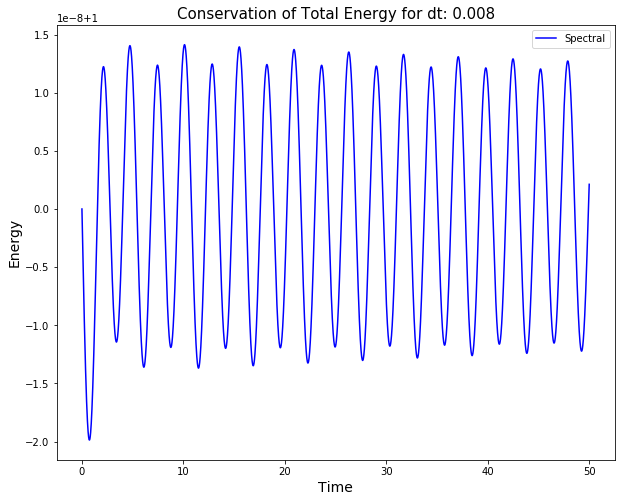

In [16]:
plot_quantity(t_grid,Energy_sol/Energy_sol[0],'Spectral','Energy',dt)

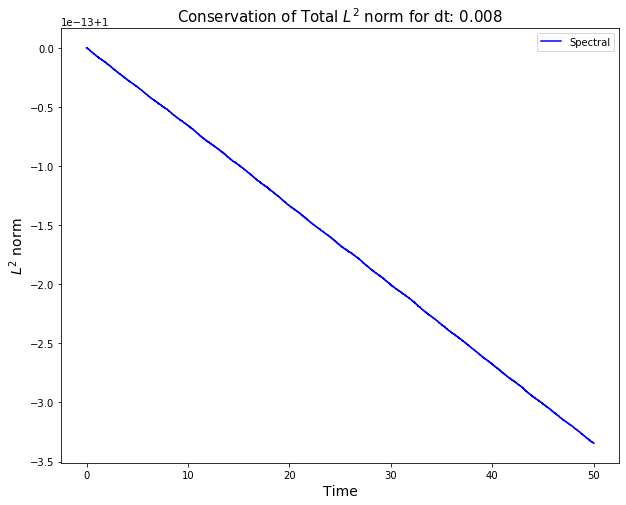

In [17]:
plot_quantity(t_grid,L2norm_sol/L2norm_sol[0],'Spectral','$L^2$ norm',dt)

### Open File

In [18]:
twostream1 = np.loadtxt("TwoStream1.txt")
twostream1 = twostream1.reshape(M_size+1,N_y+1,N_x+1)
twostream1.shape

(6001, 257, 257)

### Plot the distribution function

In [19]:
x_array = np.arange(0, L_x + dx, dx) # positions array
v_array = np.arange(v_min, v_max + dv, dv) # velocities array
Pos,Vel = np.meshgrid(x_array,v_array) # space-velocity mesh grid

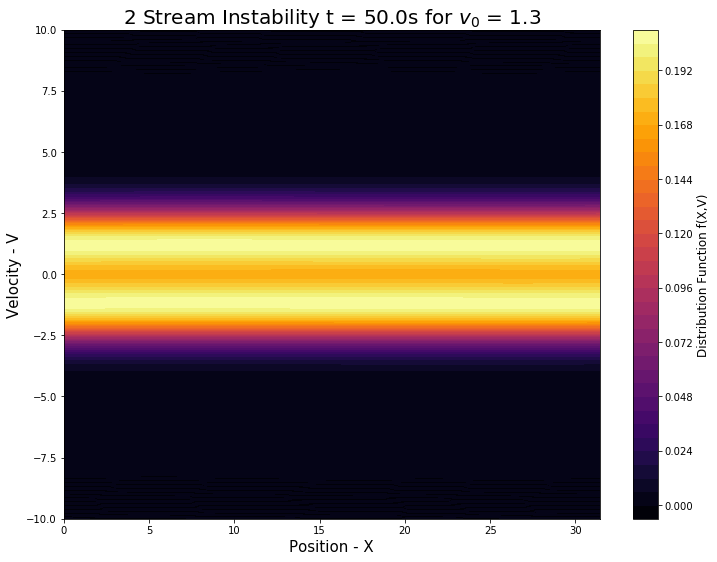

In [59]:
fig,ax = plt.subplots(1,1,figsize = (12, 9))
ti = 6000 # time to plot
cp = ax.contourf(Pos, Vel , twostream1[ti],40, cmap=cm.inferno) # Create contour plot
cbar = fig.colorbar(cp) # Add a colorbar to a plot
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12) # Label the color bar
plt.title(f'2 Stream Instability t = {ti*dt}s for $v_0$ = 1.3',fontsize = 20) # title
ax.set_xlabel('Position - X',fontsize = 15) # xlabel
ax.set_ylabel('Velocity - V',fontsize = 15) # ylabel
plt.show()

In [21]:
time_plot = [0, 1200, 2400, 3600, 4800, 6000] #times to plot

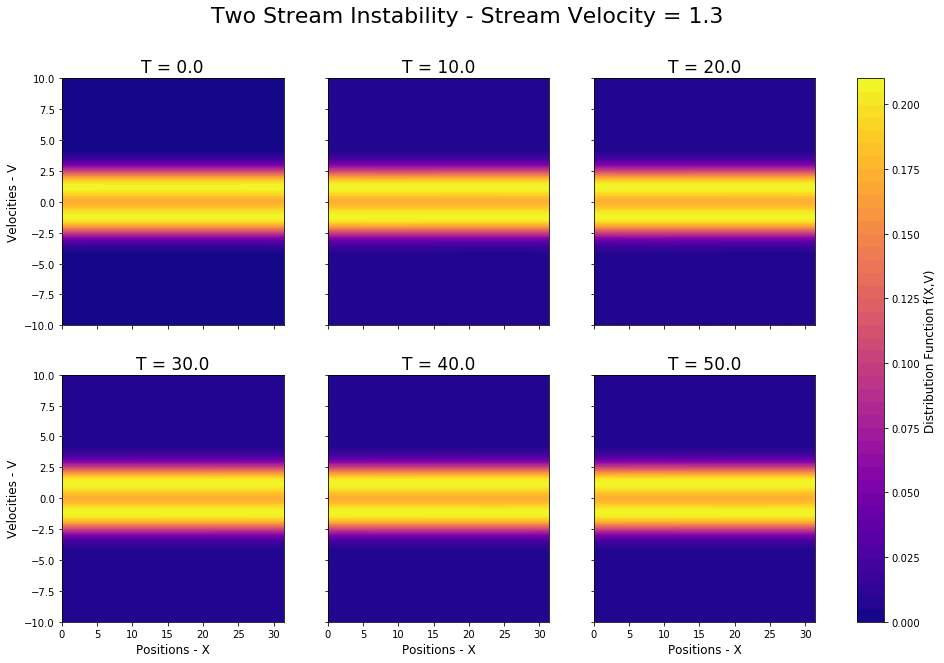

In [22]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Two Stream Instability - Stream Velocity = 1.3',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].contourf(Pos, Vel, twostream1[time_plot[ti]], 50, cmap = cm.plasma) # create contour 
        ax[i,j].set_title(f'T = {time_plot[ti]*dt}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

#### We integrate the electric field vs position

Field Energy: 
$$ \int |\nabla \phi|^2 dx = \int |E(x)|^2 dx $$

Verification:

For $v_0 = 1.3$

$$ \sqrt{\int |E(x)|^2 dx} \propto e^{\omega_i*t} $$ for $\omega_i = 0.0011$

In [29]:
integralEf1 = np.sqrt(np.array([integrate.trapz(abs(ef), dx = dx) for ef in E_field]))

wi1= 0.0011

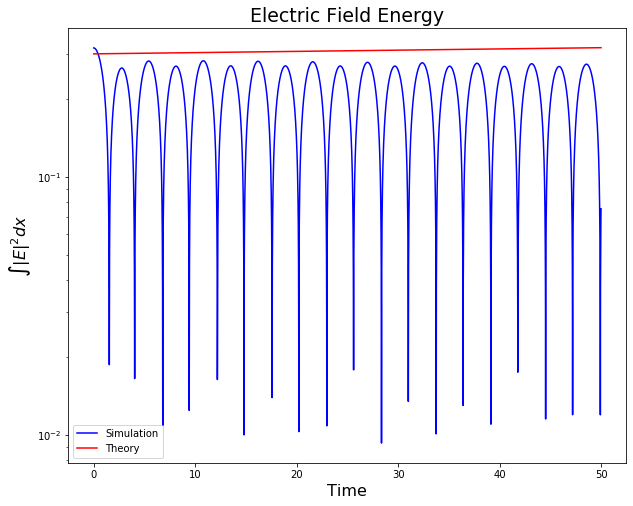

In [34]:
plt.figure(figsize=(10,8))
plt.plot(t_grid, integralEf1,c='b',label='Simulation')
plt.plot(t_grid, 0.3* np.exp(t_grid*wi1) , c = 'r' , label = 'Theory')
plt.title('Electric Field Energy',fontsize=19)
plt.xlabel('Time',fontsize=16)
plt.ylabel('$\int|E|^2 dx$',fontsize=16)
plt.yscale('log')
plt.legend()
plt.show()

### Second Run: v0 = 2.4

In [35]:
two_stream_init_cond2 = lambda x,v: 1/(2*np.sqrt(2*np.pi))*(np.exp(-(v - v0_vector[1])**2/2) + 
                                                            np.exp(-(v + v0_vector[1])**2/2)) * (1 + eps*np.cos(k_param*x))

#### Run Model

In [38]:
start_time = time.time()

objSolver2 = VlasovSolver.VlasovPoisson1D1V(two_stream_init_cond2, 0.0 ,L_x , N_x, v_min, v_max, N_y, T_max, M_size, 
                                                 'Spectral', 1 ,'TwoStream2')
Mass_sol2,Moment_sol2,Energy_sol2,L2norm_sol2,E_field2 = objSolver2.run_iteration() # run model

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  10.995755342642466


### Open File

In [39]:
twostream2 = np.loadtxt("TwoStream2.txt")
twostream2 = twostream2.reshape(M_size+1,N_y+1,N_x+1)
twostream2.shape

(6001, 257, 257)

### Plot the distribution function

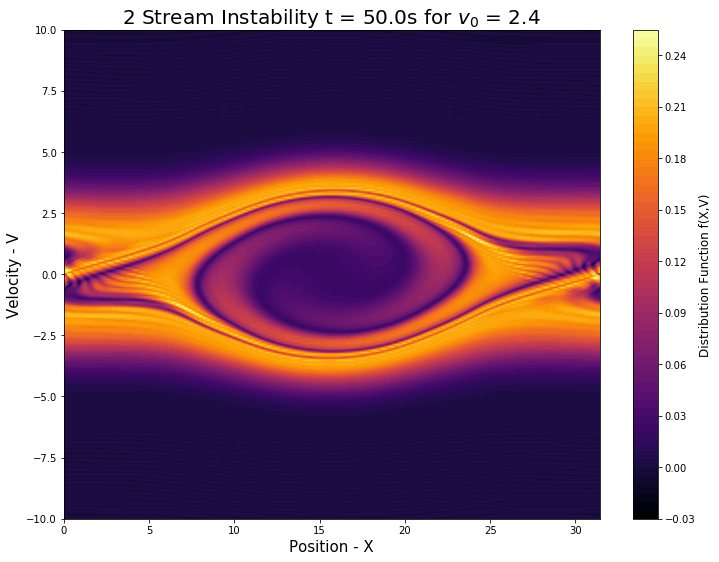

In [61]:
fig,ax = plt.subplots(1,1,figsize = (12, 9))
ti = 6000 # time to plot
cp = ax.contourf(Pos, Vel , twostream2[ti],60, cmap=cm.inferno) # Create contour plot
cbar = fig.colorbar(cp) # Add a colorbar to a plot
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12) # Label the color bar
plt.title(f'2 Stream Instability t = {ti*dt}s for $v_0$ = 2.4',fontsize = 20) # title
ax.set_xlabel('Position - X',fontsize = 15) # xlabel
ax.set_ylabel('Velocity - V',fontsize = 15) # ylabel
plt.show()

In [64]:
time_plot2 = [0, 3600, 4200 , 4800,5400,6000] #times to plot

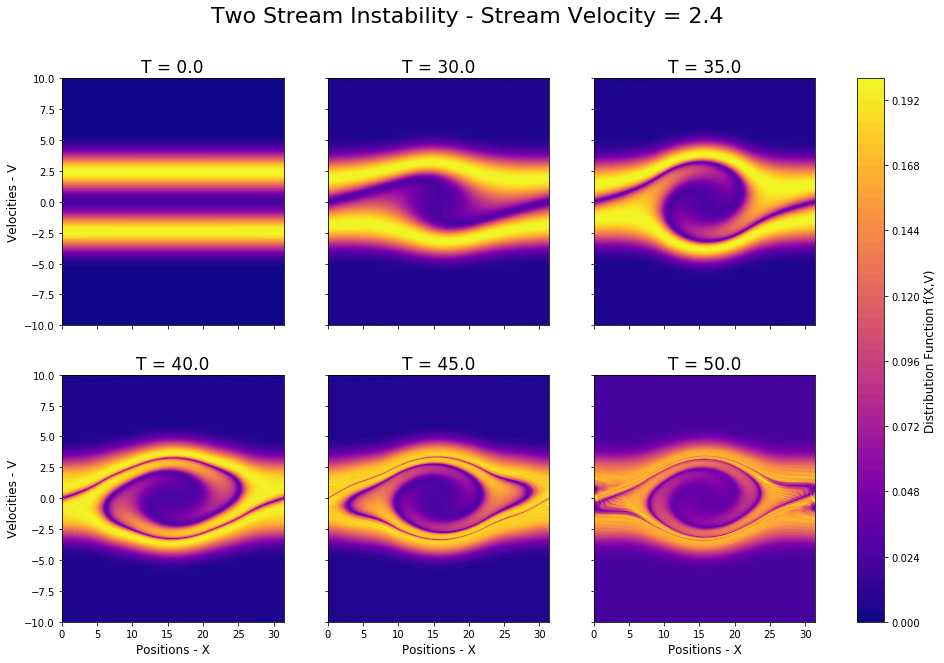

In [66]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Two Stream Instability - Stream Velocity = 2.4',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].contourf(Pos, Vel, twostream2[time_plot2[ti]], 50, cmap = cm.plasma) # create contour 
        ax[i,j].set_title(f'T = {time_plot2[ti]*dt}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

Verification:

For $v_0 = 2.4$

$$ \sqrt{\int |E(x)|^2 dx} \propto e^{\omega_i*t} $$ for $\omega_i = 0.2258$

In [43]:
integralEf2 = np.sqrt(np.array([integrate.trapz(abs(ef), dx = dx) for ef in E_field2]))

wi2= 0.2258

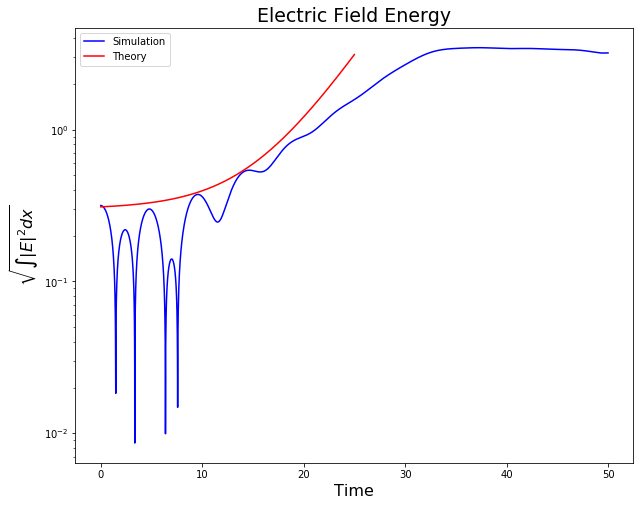

In [58]:
plt.figure(figsize=(10,8))
plt.plot(t_grid, integralEf2,c='b',label='Simulation')
plt.plot(t_grid[:3000],  0.01*np.exp(t_grid*wi2)[:3000] + 0.3 , c = 'r' , label = 'Theory')
plt.title('Electric Field Energy',fontsize=19)
plt.xlabel('Time',fontsize=16)
plt.ylabel('$\sqrt{\int|E|^2 dx}$',fontsize=16)
plt.yscale('log')
plt.legend()
plt.show()

### Third Run: $v_0$ = 3.0

In [67]:
two_stream_init_cond3 = lambda x,v: 1/(2*np.sqrt(2*np.pi))*(np.exp(-(v - v0_vector[2])**2/2) + 
                                                            np.exp(-(v + v0_vector[2])**2/2)) * (1 + eps*np.cos(k_param*x))

#### Run Model

In [68]:
start_time = time.time()

objSolver3 = VlasovSolver.VlasovPoisson1D1V(two_stream_init_cond3, 0.0 ,L_x , N_x, v_min, v_max, N_y, T_max, M_size, 
                                                 'Spectral', 1 ,'TwoStream3')
Mass_sol3,Moment_sol3,Energy_sol3,L2norm_sol3,E_field3 = objSolver3.run_iteration() # run model

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  11.143176587422689


### Open File

In [69]:
twostream3 = np.loadtxt("TwoStream3.txt")
twostream3 = twostream3.reshape(M_size+1,N_y+1,N_x+1)
twostream3.shape

(6001, 257, 257)

### Plot the distribution function

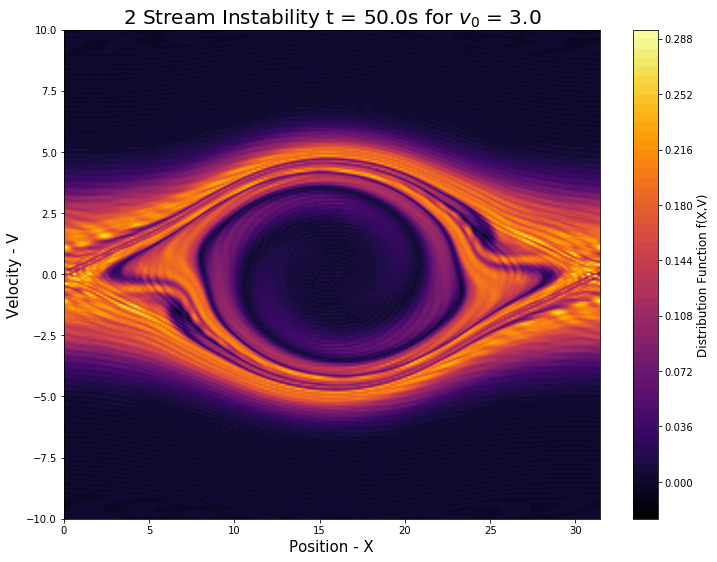

In [70]:
fig,ax = plt.subplots(1,1,figsize = (12, 9))
ti = 6000 # time to plot
cp = ax.contourf(Pos, Vel , twostream3[ti],60, cmap=cm.inferno) # Create contour plot
cbar = fig.colorbar(cp) # Add a colorbar to a plot
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12) # Label the color bar
plt.title(f'2 Stream Instability t = {ti*dt}s for $v_0$ = 3.0',fontsize = 20) # title
ax.set_xlabel('Position - X',fontsize = 15) # xlabel
ax.set_ylabel('Velocity - V',fontsize = 15) # ylabel
plt.show()

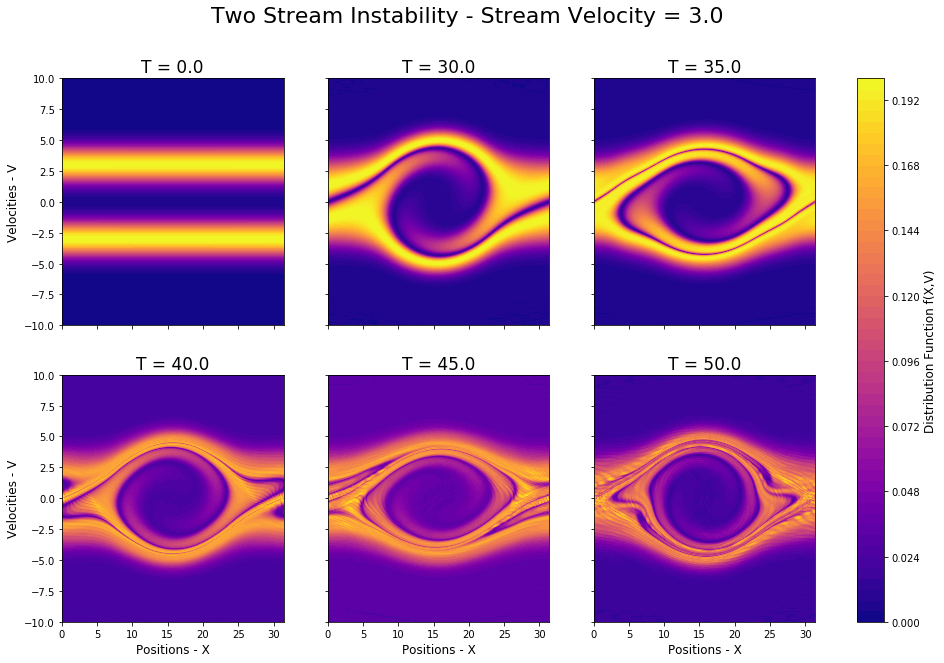

In [71]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Two Stream Instability - Stream Velocity = 3.0',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].contourf(Pos, Vel, twostream3[time_plot2[ti]], 50, cmap = cm.plasma) # create contour 
        ax[i,j].set_title(f'T = {time_plot2[ti]*dt}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

Verification:

For $v_0 = 3.0$

$$ \sqrt{\int |E(x)|^2 dx} \propto e^{\omega_i*t} $$ for $\omega_i = 0.2845$

In [72]:
integralEf3 = np.sqrt(np.array([integrate.trapz(abs(ef), dx = dx) for ef in E_field3]))

wi3 = 0.2258

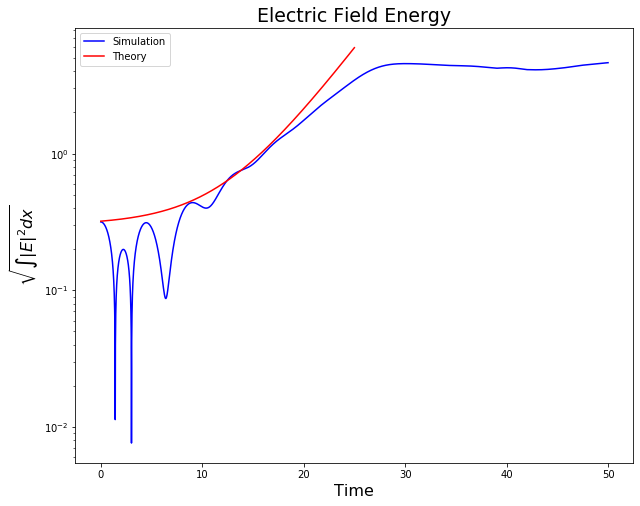

In [82]:
plt.figure(figsize=(10,8))
plt.plot(t_grid, integralEf3,c='b',label='Simulation')
plt.plot(t_grid[:3000],  0.02*np.exp(t_grid*wi3)[:3000] +0.3 , c = 'r' , label = 'Theory')
plt.title('Electric Field Energy',fontsize=19)
plt.xlabel('Time',fontsize=16)
plt.ylabel('$\sqrt{\int|E|^2 dx}$',fontsize=16)
plt.yscale('log')
plt.legend()
plt.show()